In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
df = pd.read_csv('training_set.csv')
df = df.set_index('timestamp')
df = df.drop('target', axis=1)

In [3]:
df.head(5)

high      low     open    close
timestamp                                              
2018-01-14 00:00:00  14399.9  14378.5  14396.3  14384.3
2018-01-14 00:05:00  14387.3  14375.0  14384.1  14384.4
2018-01-14 00:10:00  14399.0  14384.2  14384.4  14388.8
2018-01-14 00:15:00  14399.0  14355.0  14388.7  14372.0
2018-01-14 00:20:00  14391.0  14350.0  14370.2  14355.3

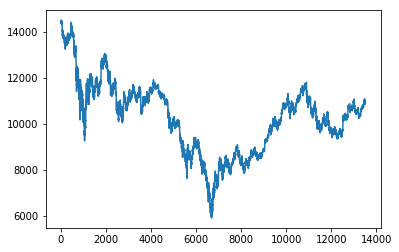

In [4]:
plt.plot(df.close.values)

In [6]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

def normalize_data(df):
    min_max_scaler = MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df
  
def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = []
    
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [7]:
df_stock_norm = normalize_data(df)

seq_len = 20
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)

In [8]:
x_train

array([[[ 0.98826921,  0.98956883,  0.98796358,  0.98761451],
        [ 0.98679261,  0.98916272,  0.98654479,  0.98762615],
        [ 0.98816374,  0.99023021,  0.98657968,  0.98813834],
        ..., 
        [ 1.        ,  0.98626195,  0.98840549,  0.99750893],
        [ 0.99997656,  0.98730623,  1.        ,  0.99454061],
        [ 1.        ,  0.99713404,  0.99348754,  0.99742745]],

       [[ 0.98679261,  0.98916272,  0.98654479,  0.98762615],
        [ 0.98816374,  0.99023021,  0.98657968,  0.98813834],
        [ 0.98816374,  0.98684211,  0.98707974,  0.98618273],
        ..., 
        [ 0.99997656,  0.98730623,  1.        ,  0.99454061],
        [ 1.        ,  0.99713404,  0.99348754,  0.99742745],
        [ 1.        ,  0.99741251,  0.99938364,  0.99550677]],

       [[ 0.98816374,  0.99023021,  0.98657968,  0.98813834],
        [ 0.98816374,  0.98684211,  0.98707974,  0.98618273],
        [ 0.98722621,  0.98626195,  0.9849283 ,  0.98423877],
        ..., 
        [ 1.        ,  0

In [9]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) 
        start = 0 
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [10]:
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

In [11]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [ ]:
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(y_train_pred[:, 0])
plt.legend(['open', 'high', 'low', 'close'])

In [ ]:
plt.plot(y_test_pred[:, 0])
plt.legend(['open', 'high', 'low', 'close'])